In [1]:
# Base
# -----------------------------------
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
from IPython.display import display


# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# Project Description

**Cookie Cats** adalah game puzzle mobile yang sangat populer yang dikembangkan oleh **Tactile Entertainment**. Game ini merupakan puzzle klasik bergaya **"connect three"**, di mana pemain harus menghubungkan ubin dengan warna yang sama untuk membersihkan papan dan memenangkan level. Game ini juga menampilkan kucing yang bernyanyi.

Saat pemain maju dalam permainan, mereka akan menemui **time gate** yang memaksa mereka untuk menunggu beberapa waktu sebelum dapat melanjutkan permainan mereka, atau kalau mereka tidak mau menunggu para player bisa melakukan **pembelian dalam aplikasi**. Dalam proyek ini, kita akan menganalisis hasil **A/B test** di mana gate pertama dalam **Cookie Cats** dipindahkan dari **level 30 ke level 40**. Secara khusus, kita akan menganalisis dampaknya terhadap **retention player** dan **jumlah game rounds** yang dimainkan.

## **Tentang Data**
Data yang digunakan berasal dari **90.189 pemain** yang menginstal game selama periode **A/B test** berlangsung. Variabel dalam dataset ini meliputi:

- **userid** → Nomor unik yang mengidentifikasi setiap pemain.
- **version** → Grup pemain, apakah termasuk **control group** (gate_30 - time gate di level 30) atau **test group** (gate_40 - time gate di level 40).
- **sum_gamerounds** → Jumlah game rounds yang dimainkan oleh pemain selama **minggu pertama** setelah instalasi.
- **retention_1** → Apakah pemain kembali bermain **1 hari** setelah menginstal?
- **retention_7** → Apakah pemain kembali bermain **7 hari** setelah menginstal?

Saat pemain menginstal game, mereka secara **acak** ditempatkan ke dalam grup **gate_30** atau **gate_40**.

---

## **Proses A/B Testing**
1. Memahami **masalah bisnis** dan **struktur data**  
2. Mendeteksi dan menyelesaikan **masalah dalam data** (Missing Value, Outliers, Unexpected Value)  
3. Melihat **ringkasan statistik dan visualisasi data**  
4. Melakukan **pengujian hipotesis** dan mengecek asumsi dasar:  
    - Cek **normalitas** dan **homogenitas**  
    - Melakukan uji statistik (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)  
5. Mengevaluasi hasil uji coba  
6. Menarik kesimpulan  
7. Memberikan rekomendasi keputusan bisnis kepada **customer, director, atau CEO**  

# 1. Dataset Information

In [3]:
folder = "cookie cats AB testing"
path = f"{folder}/cookie_cats.csv"

def load(path, info=True):


    if ".csv" in path:
        read = pd.read_csv(path)
    elif ".xlsx" in path:
        read = pd.read_excel(path)
    else:
        raise ValueError("Unsupported file format. Please provide a CSV or XLSX file.")

    # Jika parameter info=True, maka tampilkan informasi dataset
    if info:
        if len(read) > 0:  # Memastikan dataset tidak kosong
            
            # Menampilkan jumlah baris (observation) dan jumlah kolom (features)
            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")

            # Menampilkan tipe data setiap kolom dalam dataset
            print("# DTYPES -----------------------------")

            # Menampilkan kolom bertipe object (teks)
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")

            # Menampilkan kolom bertipe integer
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")

            # Menampilkan kolom bertipe float
            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")

            # Menampilkan kolom bertipe boolean
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")

            # Mengecek apakah ada missing values (nilai yang hilang)
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", 
                  np.where(read.isnull().values.any() == False, 
                           "No missing value!", "Data includes missing value!"), "\n")

            # Menangkap informasi memori dataset
            buf = io.StringIO()  # Membuat buffer string untuk menangkap output
            read.info(buf=buf)  # Menjalankan info() dan menyimpannya dalam buffer
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()  
            # Memproses string untuk mendapatkan penggunaan memori
            print("# MEMORY USAGE ---------------------- \n", info)  # Menampilkan penggunaan memori dataset

        else:
            print("# Data did not import!")  # Jika dataset kosong, tampilkan pesan ini

    return read  # Mengembalikan dataset yang telah dibaca

# Memanggil fungsi load() dengan path file
ab = load(path, info=True)

# Menampilkan 5 baris pertama dari dataset untuk melihat sekilas isinya
print(ab.head())


# DIMENSIONS -------------------------
Observation: 90189 Column: 5 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 1 
 ['version'] 

Integer Variables: 
 # of Variables: 2 
 ['userid', 'sum_gamerounds'] 

Bool Variables: 
 # of Variables: 2 
 ['retention_1', 'retention_7'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 2.2+ MB
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


# 2. Exploratory Data Analysis (EDA)

In [5]:
# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [6]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


In [7]:
ab['sum_gamerounds'].sort_values(ascending=False)

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
         ...  
59687        0
23707        0
59670        0
59645        0
45094        0
Name: sum_gamerounds, Length: 90189, dtype: int64

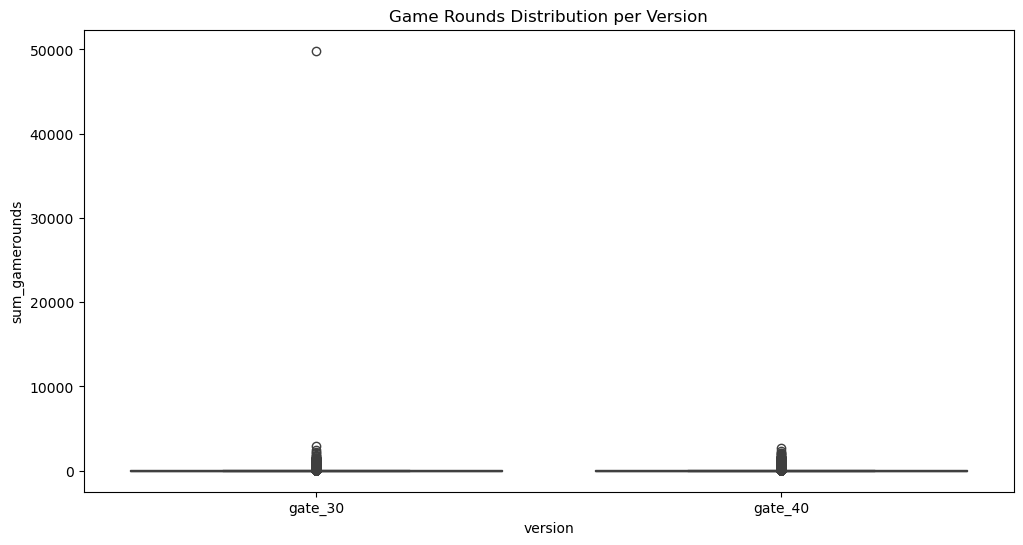

In [8]:
# Plot distribusi jumlah game rounds berdasarkan versi
plt.figure(figsize=(12,6))
sns.boxplot(x="version", y="sum_gamerounds", data=ab)
plt.title("Game Rounds Distribution per Version")
plt.show()

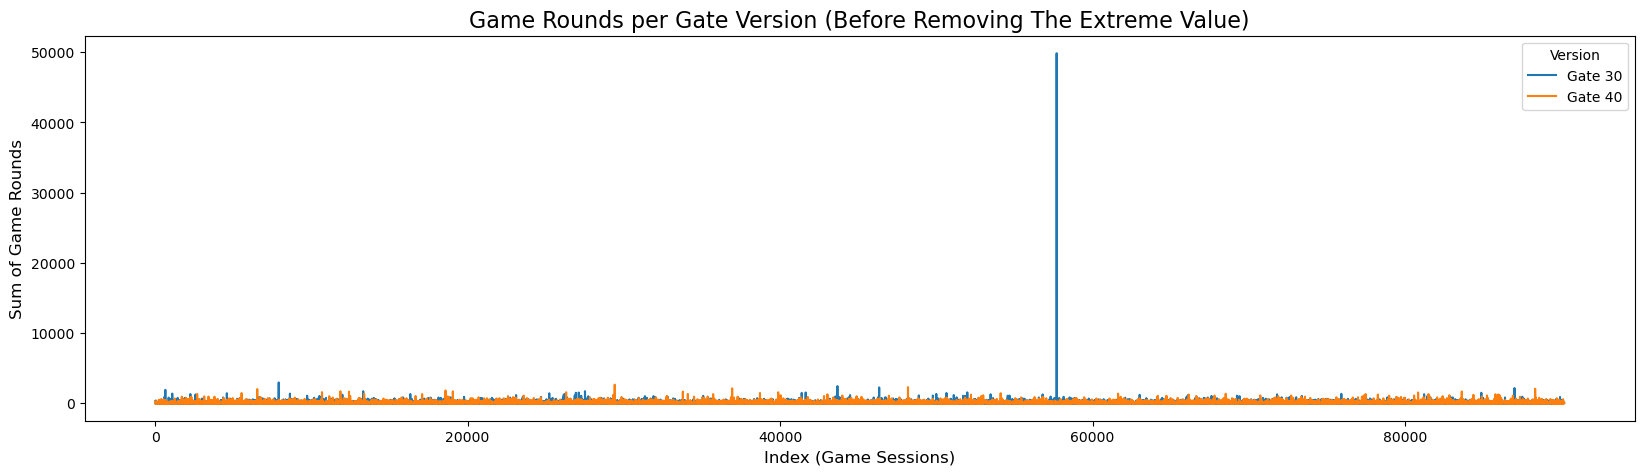

In [9]:
# Plot the sum of game rounds per version over time (or index)
plt.figure(figsize=(20, 5))

# Plot line chart for both 'gate_30' and 'gate_40' versions
ab[ab.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(
    linestyle='-', label="Gate 30"
)
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(
    linestyle='-', label="Gate 40"
)

# Title and labels
plt.title('Game Rounds per Gate Version (Before Removing The Extreme Value)', fontsize=16)
plt.xlabel('Index (Game Sessions)', fontsize=12)
plt.ylabel('Sum of Game Rounds', fontsize=12)
plt.legend(title='Version')
plt.xticks(rotation=0)

plt.show()

## Conclusion
Adanya outliers atau extreme value di sum_gamerounds yang terjadi di versi gate_30 dengan value sebesar 49.854, yang menyebabkan visualisasi data distribusi sulit untuk dibaca. Maka untuk menjaga reliability data untuk pengujian statistik dan tidak membuat adanya kesalahan di hasil pengujian, diputuskan untuk membuang outliers di dataset yang dipakai.

## Selanjutnya data outliers akan dibuang

In [12]:
# Membuang outliers dengan hanya memakai value sum_gamerounds di bawah value maksimal
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


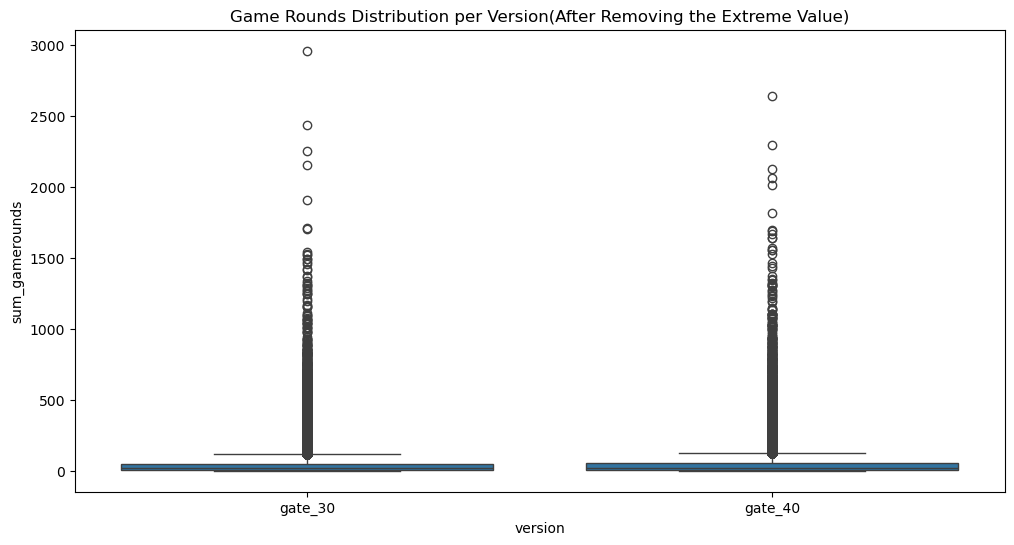

In [13]:
# Plot distribusi jumlah game rounds berdasarkan versi
plt.figure(figsize=(12,6))
sns.boxplot(x="version", y="sum_gamerounds", data=ab)
plt.title("Game Rounds Distribution per Version(After Removing the Extreme Value)")
plt.show()

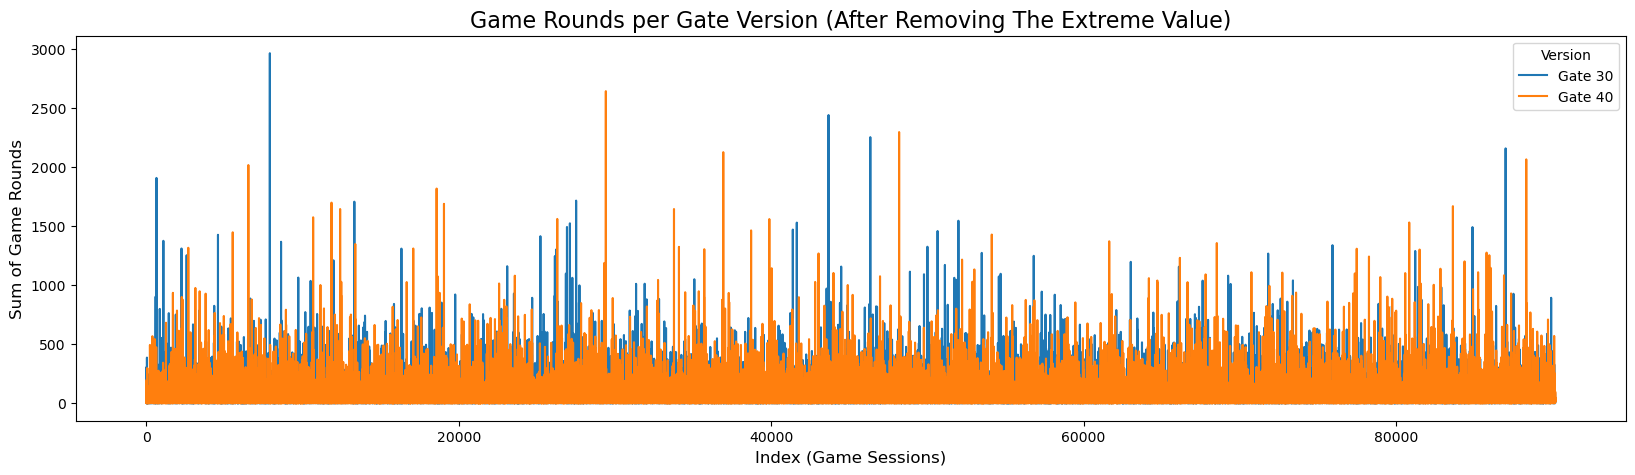

In [14]:
# Plot the sum of game rounds per version(or index)
plt.figure(figsize=(20, 5))

# Plot line chart for both 'gate_30' and 'gate_40' versions
ab[ab.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(
    linestyle='-', label="Gate 30"
)
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(
    linestyle='-', label="Gate 40"
)

# Title and labels
plt.title('Game Rounds per Gate Version (After Removing The Extreme Value)', fontsize=16)
plt.xlabel('Index (Game Sessions)', fontsize=12)
plt.ylabel('Sum of Game Rounds', fontsize=12)
plt.legend(title='Version')
plt.xticks(rotation=0)

plt.show()

### Setelah extreme value atau outlier sudah dibuang maka visualisasi data menjadi lebih jelas dan bisa dibaca dengan baik

## Bagaimana dengan sum_gamerounds dilihat dari variabel-variabel lain?

### 1. User counts per sum_gamerounds

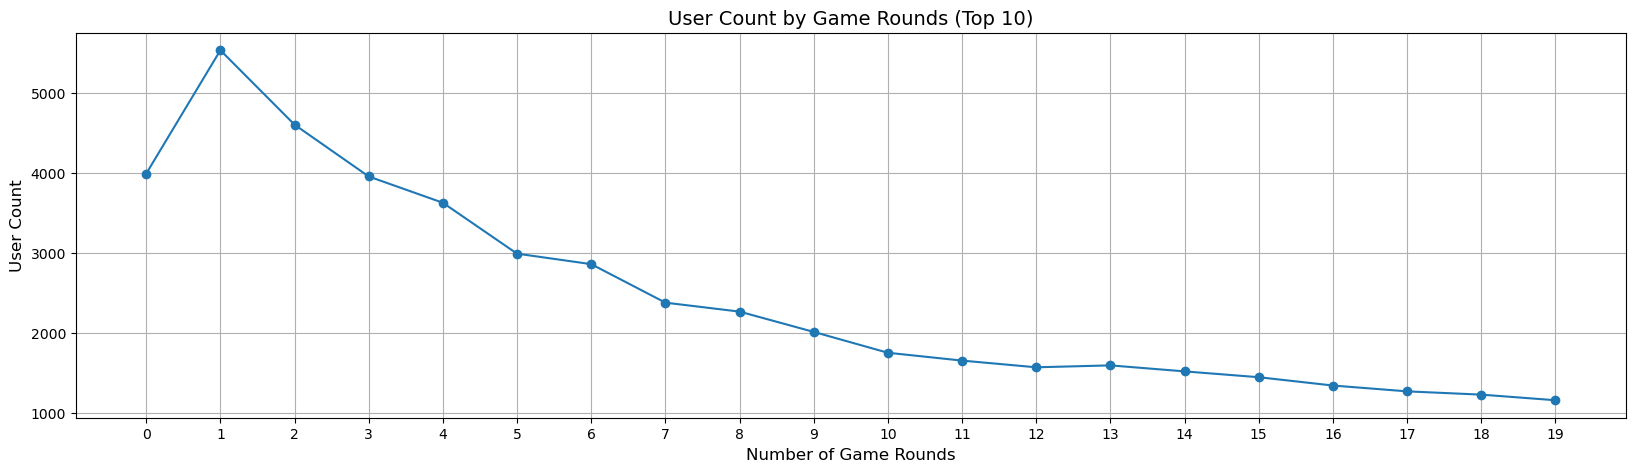

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [18]:
# Grouping by sum_gamerounds and counting userid occurrences
ab_grouped = ab.groupby("sum_gamerounds").userid.count().reset_index()

# Selecting the first 10 rows
ab_grouped_top10 = ab_grouped.head(20)

# Plotting the line chart
plt.figure(figsize=(20, 5))
plt.plot(ab_grouped_top10["sum_gamerounds"], ab_grouped_top10["userid"], marker="o", linestyle="-")

# Customizing the chart
plt.title("User Count by Game Rounds (Top 10)", fontsize=14)
plt.xlabel("Number of Game Rounds", fontsize=12)
plt.ylabel("User Count", fontsize=12)
plt.xticks(ab_grouped_top10["sum_gamerounds"])

# Show plot
plt.grid(True)
plt.show()

ab_grouped_top10

__Users Menginstal Game, tapi 3.994 Users Tidak Pernah Memainkannya__   
Beberapa alasan yang mungkin menjelaskan situasi ini:  
- Mereka tidak memiliki waktu luang untuk bermain game.
- Pengguna mungkin lebih suka bermain game lain atau sudah memiliki game lain yang mereka mainkan.
- Beberapa pengguna tidak menyukai aplikasi ini.
- Ketidak sengajaan dari users saat melihat ads dari game cool cats dan tidak sengaja mengklik install 


__Jumlah pengguna berkurang seiring dengan progress kemajuan level__  
- Sebagian besar pengguna hanya memainkan game pada tahap awal dan tidak melanjutkan ke level berikutnya.
- Tactile Entertainment perlu memahami alasan mengapa pengguna berhenti bermain game (user churn).
- Melakukan riset dan mengumpulkan data tentang game dan perilaku pengguna dapat membantu memahami penyebab churn.
- Tingkat kesulitan game dapat diukur untuk mengetahui apakah ini berpengaruh terhadap retensi pemain.
- Hadiah atau insentif dalam game mungkin dapat membantu meningkatkan retensi pemain.

In [20]:
# How many users reached gate 30 & gate 40 levels?
ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

### 2. sum_gamerounds per gate version

In [22]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


Bisa dilihat dari __summary statistics antara control group gate_30 dan test group group_40 hasilnya cukup mirip.__

Pertanyaan selanjutnya, ___apakah dua group tersebut memiliki statistik signifikan dalam variabel retention_1 dan retention_7 ?___ Maka analisis selanjutnya akan membahas pertanyaan ini secara statistik.

## Mengecek statistik dan retention rates user di hari pertama dan hari ketujuh

In [25]:
# Membuat DataFrame untuk menghitung jumlah pengguna berdasarkan retensi hari ke-1 dan hari ke-7
pd.DataFrame({
    "RET1_COUNT": ab["retention_1"].value_counts(),  # # Jumlah users yang kembali bermain setelah 1 hari
    "RET7_COUNT": ab["retention_7"].value_counts(),  # # Jumlah users yang kembali bermain setelah 7 hari
    "RET1_RATIO": ab["retention_1"].value_counts() / len(ab),  # # Persentase users yang kembali setelah 1 hari dari total users
    "RET7_RATIO": ab["retention_7"].value_counts() / len(ab)   # # Persentase users yang kembali setelah 7 hari dari total users
})

# len(ab) adalah jumlah baris di dataset 'ab' atau dalam kata lain bisa disebut juga sebagai jumlah users  

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.5548,0.8139
True,40153,16780,0.4452,0.1861


- 55 percent of the players didn't play the game 1 day after installing
- 81 percent of the players didn't play the game 7 day after installing

In [27]:
ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640

In [28]:
ab.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8501 105.0000 160.1175 179.3586  2961
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294

### Insight: 
Dilihat dari hasil analisis statistik __controlled group gate_30__ dan __test group gate_40__ terhadap retention_1 dan retention_7 bisa dilihat kemiripan di semua aspek baik dalam jumlah users dan summary statisticsnya. 

In [30]:
ab["Retention"] = np.where((ab.retention_1 == True) & (ab.retention_7 == True), 1,0) #Mengconvert True/False menjadi 1 dan 0
ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

Ketika variabel retention_1 dan retention_7 digabungkan, summary statisticnya dari kedua group juga menunjukkan hasil yang serupa.

# 3. Menentukan Hipotesis
Dalam A/B Testing, kita menetapkan hipotesis nol (H₀) dan alternatif (H₁):

- **H₀ (Null Hypothesis): Tidak ada perbedaan signifikan antara Gate 30 dan Gate 40.**  
- **H₁ (Alternative Hypothesis): Ada perbedaan signifikan antara Gate 30 dan Gate 40.**

# 4. A/B Testing  
Assumptions:
- Check normality
- If Normal Distribution, check homogeneity
  
Steps:
- Split & Define Control Group & Test Group
- Apply Shapiro Test for normality
- If parametric apply Levene Test for homogeneity of variances
- If Parametric + homogeneity of variances apply T-Test
- If Parametric - homogeneity of variances apply Welch Test
- If Non-parametric apply Mann Whitney U Test directly

In [34]:
# Split data into Control Group (Gate 30) and Test Group (Gate 40)
control_group = ab[ab["version"] == "gate_30"]["sum_gamerounds"]
test_group = ab[ab["version"] == "gate_40"]["sum_gamerounds"]

# Check Normality using Shapiro-Wilk Test (sampling 500 data points for efficiency)
shapiro_control = stats.shapiro(control_group.sample(500, random_state=42))
shapiro_test = stats.shapiro(test_group.sample(500, random_state=42))

# Check Homogeneity of Variances using Levene’s Test (if normal)
if shapiro_control.pvalue > 0.05 and shapiro_test.pvalue > 0.05:
    levene_test = stats.levene(control_group, test_group)
else:
    levene_test = None  # Tidak perlu uji homogeneity jika data tidak normal

# Perform Appropriate Statistical Test
if shapiro_control.pvalue > 0.05 and shapiro_test.pvalue > 0.05:
    if levene_test and levene_test.pvalue > 0.05:
        # If normal & variances are homogeneous -> T-Test
        test_stat, p_value = stats.ttest_ind(control_group, test_group, equal_var=True)
        test_type = "T-Test (Parametric with equal variances)"
    else:
        # If normal & variances are NOT homogeneous -> Welch Test
        test_stat, p_value = stats.ttest_ind(control_group, test_group, equal_var=False)
        test_type = "Welch Test (Parametric with unequal variances)"
else:
    # If not normal -> Mann-Whitney U Test
    test_stat, p_value = stats.mannwhitneyu(control_group, test_group)
    test_type = "Mann-Whitney U Test (Non-Parametric)"

# Store Results in DataFrame
test_results = pd.DataFrame({
    "Metric": [
        "Normality (Control Group)", 
        "Normality (Test Group)", 
        "Homogeneity (Levene Test)", 
        "Test Type Used", 
        "Test Statistic", 
        "P-Value"
    ],
    "Value": [
        shapiro_control.pvalue, 
        shapiro_test.pvalue, 
        levene_test.pvalue if levene_test else "Not Applicable", 
        test_type, 
        test_stat, 
        p_value
    ]
})

# Display the results in Jupyter Notebook
display(test_results)

,Metric,Value
0,Normality (Control Group),0.0000
1,Normality (Test Group),0.0000
2,Homogeneity (Levene Test),Not Applicable
3,Test Type Used,Mann-Whitney U Test (Non-Parametric)
4,Test Statistic,1024285761.5000
5,P-Value,0.0509


# Kesimpulan Hasil A/B Testing - Cookie Cats

## **1. Split & Define Control Group & Test Group**
**Sudah dilakukan** → Data dibagi menjadi **Gate 30 (Control Group) dan Gate 40 (Test Group)** berdasarkan kolom `version`.  
**Konsekuensi**: Kita siap untuk menguji apakah ada perbedaan signifikan antara dua grup ini.

---

## **2. Uji Normalitas (Shapiro-Wilk Test)**
- **P-Value Control Group = 0.0000**  
- **P-Value Test Group = 0.0000**  

**Interpretasi:**  
- **Karena p-value < 0.05, data tidak berdistribusi normal.**  
- **Konsekuensi**:
    - Kita **tidak bisa menggunakan uji statistik parametrik** seperti T-Test atau Welch Test.  
    - Harus langsung menggunakan **Mann-Whitney U Test** (non-parametrik).

---

## **3. Uji Homogenitas Varians (Levene Test)**
- **Tidak dilakukan karena data tidak normal.**  
- **Konsekuensi**:
    - Uji Levene hanya dilakukan jika data **normal** untuk mengecek apakah varians antar grup sama atau tidak.  
    - Karena data **tidak normal**, kita langsung menggunakan **Mann-Whitney U Test**.

---

## **4. Uji Statistik yang Digunakan**
- **Mann-Whitney U Test (Non-Parametric)**  
- **Kenapa pakai Mann-Whitney U Test?**  
    - **Karena data tidak normal**, kita tidak bisa menggunakan T-Test atau Welch Test.  
    - Mann-Whitney U Test **cocok untuk membandingkan dua grup yang tidak berdistribusi normal**.

---

## **5. Hasil Uji Mann-Whitney U Test**
- **Test Statistic = 102,428,576.5000**  
- **P-Value = 0.0509**  

**Interpretasi P-Value:**  
- **Jika p-value < 0.05** → Ada perbedaan signifikan antara Gate 30 dan Gate 40.  
- **Jika p-value ≥ 0.05** → Tidak ada perbedaan signifikan, perubahan yang diuji tidak berdampak.  

**Karena p-value = 0.0509 (tidak signifikan), kita tidak bisa menyimpulkan bahwa Gate 40 lebih baik dari Gate 30.**  

---

## **Kesimpulan Akhir & Konsekuensi**
- **Tidak ada perbedaan signifikan antara Gate 30 dan Gate 40 berdasarkan uji statistik.**  
- **Keputusan bisnis:** **Tidak ada bukti kuat untuk mengganti Gate 30 dengan Gate 40.**  
- **Jika ingin lebih yakin, bisa melakukan analisis tambahan seperti:**   
   - **Segmentasi users** (misalnya pemain aktif vs pemain baru).  
   - **A/B Testing ulang dengan lebih banyak data** untuk melihat apakah hasil tetap konsisten.  

**Kesimpulan akhir: Untuk saat ini, Gate 30 tetap menjadi pilihan yang lebih aman karena tidak ada bukti kuat bahwa Gate 40 memberikan hasil yang lebih baik.**  

## Segmentasi dengan high activity users (activity lebih besar dari median)

In [37]:
ab["high_activity"] = ab["sum_gamerounds"] > ab["sum_gamerounds"].median()
control_high = ab[(ab["version"] == "gate_30") & (ab["high_activity"])]["sum_gamerounds"]
test_high = ab[(ab["version"] == "gate_40") & (ab["high_activity"])]["sum_gamerounds"]

stats.mannwhitneyu(control_high, test_high)  # Uji ulang untuk high-activity users

MannwhitneyuResult(statistic=251388409.5, pvalue=0.06280076781560827)

## **Kesimpulan dari Hasil Mann-Whitney U Test untuk High-Activity Users**
**Dari hasil uji Mann-Whitney U Test untuk pengguna dengan aktivitas tinggi, kita mendapatkan:**  
- Test Statistic = 251,388,409.5  
- P-Value = 0.0628 → Lebih besar dari 0.05 (tidak signifikan).
- Artinya, tidak ada perbedaan yang cukup kuat secara statistik antara pengguna aktif yang bermain di Gate 30 dan Gate 40.


**Kesimpulan:**  
- Tidak ada bukti signifikan bahwa Gate 40 lebih baik daripada Gate 30 bagi pengguna dengan aktivitas tinggi.
- Gate 40 tidak meningkatkan jumlah game rounds secara signifikan bagi pemain yang sering bermain.

**Maka step selanjutnya untuk A/B Testing ulang dengan lebih banyak data** untuk melihat apakah hasil tetap konsisten.  